In [629]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score,pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy import interpolate
from scipy.signal import convolve
import time
import sys
from BLCC import MixtureModelBernoulli

In [311]:
data_proj = TSNE(perplexity=26,random_state=100).fit_transform(df_cupid_numeric)
plt.plot(data_proj[:,0],data_proj[:,1],".g")

KeyboardInterrupt: 

In [ ]:


def tsne_plots(df,perplexities = [5,10,20,30,40,50],rand_states=[100,200],figsize=(10,5),tight_layout=True):
    plt.figure(figsize=figsize)
    count = 1
    for p in perplexities:
        for r in rand_states:
            plt.subplot(2,3,count)
            data_proj = TSNE(perplexity=p,random_state=r).fit_transform(df)
            plt.plot(data_proj[:,0],data_proj[:,1],".g")
            plt.title(f"TSNE Plot\nPerplexity={p}\nRandState:{r}")
            count+=1
    if tight_layout:
        plt.tight_layout()
    
perplexities = [5,10,20,30,40,50]
rand_states = [101,250]

tsne_plots(df_cupid_numeric,perplexities,rand_states)

# Youtube Trendy videos

https://www.kaggle.com/datasnaek/youtube-new?select=MXvideos.csv


here we have the top 200 trending videos every day for about 200 days. 


**Columns of dataframe**
the url from a video can be found by https://www.youtube.com/watch?v= 
then putting in the video id



* video id
    * thumbnail
    * current views
* trending date
    * num days on trending
* title
    * number of different words
    * number of exclamation marks and stuff
    * number of capital letters
* channel
     * _sub count_
* pubish date
* tags
    * number of tags they have in common?
* _num views_
* _num likes_
* _num dislikes_


Features used for clustering
* percent Change
    * _num views_
    * _num likes_
    * _num dislikes_
    

Features used for post analysis
* thumbnail
    * pca or NMF
* current views
* title
    * frequency of the same words
    * number of exclamation marks and stuff
    * number of capital letters (not including not at the beginning of words)
* channel sub count
* tags
    * frequency of tags
* Average graphs for pca
    * _num views_
    * _num likes_
    * _num dislikes_

In [295]:
df_yt_us_raw = pd.read_csv("data/youtube/USvideos.csv")
df_yt_us_raw["trending_date"] = pd.to_datetime(df_yt_us_raw["trending_date"],format="%y.%d.%m")

display(df_yt_us_raw.head(2))
print(f"num unique videos: {len(df_yt_us_raw['video_id'].unique())}")

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."


num unique videos: 6351


In [388]:
# Change per day dataframe
df_chng_per_day_v = df_yt_us_raw[["video_id","trending_date","views","likes","dislikes"]].copy()
df_chng_per_day_v = pd.pivot_table(df_chng_per_day_v,
                           columns="video_id",
                           index="trending_date",
                           values="views")
df_chng_per_day_v = df_chng_per_day_v.sort_values(by='trending_date')
num_rows = len(df_chng_per_day_v)
num_cols = len(df_chng_per_day_v.columns)
display(df_chng_per_day_v)

video_id,-0CMnp02rNY,-0NYY8cqdiQ,-1Hm41N0dUs,-1yT-K3c6YI,-2RVw2_QyxQ,-2aVkGcI7ZA,-2b4qSoMnKE,-2wRFv-mScQ,-35jibKqbEo,-37nIo_tLnk,...,zuMkDVbThVw,zuRd_Eneuk8,zuVxgSvyffk,zvFQWPEuNJA,zvjqcoiOPbE,zwEn-ambXLw,zxUwbflE1SY,zxwfDlhJIpw,zy0b9e40tK8,zzQsGL_F9_c
trending_date,,,,,,,,,,,,,,,,,,,,,
2017-11-14,NaN,NaN,NaN,NaN,67429.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,378750.0,NaN
2017-11-15,NaN,NaN,NaN,NaN,69786.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,190669.0,NaN,NaN,NaN
2017-11-16,NaN,NaN,NaN,NaN,71089.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,207712.0,NaN,NaN,NaN
2017-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,214925.0,NaN,NaN,NaN
2017-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,220365.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-10,792613.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-11,800359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [389]:
df_chng_per_day_v.to_csv("test.csv")
df_chng_per_day_v_shifted = df_chng_per_day_v.copy()
for c in df_chng_per_day_v_shifted.columns:
    # first valid position
    num_shit = df_chng_per_day_v_shifted[c].index.get_loc(df_chng_per_day_v_shifted[c].first_valid_index())
    df_chng_per_day_v_shifted[c] = df_chng_per_day_v_shifted[c].shift(-1*num_shit)
    

df_chng_per_day_v_shifted = df_chng_per_day_v_shifted.reset_index(drop=True)

# Find the last row weith values
last_index = max(df_chng_per_day_v_shifted.index[df_chng_per_day_v_shifted.isna().sum(axis=1) < num_cols])

df_chng_per_day_v_shifted = df_chng_per_day_v_shifted[:last_index+1]

df_chng_per_day_v_shifted.to_csv("test2.csv")
display(df_chng_per_day_v_shifted)

video_id,-0CMnp02rNY,-0NYY8cqdiQ,-1Hm41N0dUs,-1yT-K3c6YI,-2RVw2_QyxQ,-2aVkGcI7ZA,-2b4qSoMnKE,-2wRFv-mScQ,-35jibKqbEo,-37nIo_tLnk,...,zuMkDVbThVw,zuRd_Eneuk8,zuVxgSvyffk,zvFQWPEuNJA,zvjqcoiOPbE,zwEn-ambXLw,zxUwbflE1SY,zxwfDlhJIpw,zy0b9e40tK8,zzQsGL_F9_c
0,475965.0,563746.0,1566807.0,129360.0,67429.0,1012527.0,84744.0,703371.0,545655.0,2863.0,...,41685.0,706989.0,32151.0,713397.0,334173.0,114133.0,190669.0,3134765.0,378750.0,154206.0
1,605506.0,NaN,1882352.0,198315.0,69786.0,1433932.0,291653.0,900722.0,865901.0,2987.0,...,45089.0,1178822.0,95719.0,727057.0,614700.0,140357.0,207712.0,5434079.0,NaN,199041.0
2,705986.0,NaN,2058516.0,218227.0,71089.0,1837557.0,NaN,931190.0,1103258.0,3052.0,...,47675.0,1554846.0,114676.0,740854.0,796517.0,153168.0,214925.0,6501880.0,NaN,NaN
3,754273.0,NaN,NaN,231341.0,NaN,2390558.0,NaN,1036300.0,1321606.0,3085.0,...,49823.0,1761658.0,119626.0,NaN,944020.0,162520.0,220365.0,7105747.0,NaN,NaN
4,792613.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1577171.0,3111.0,...,51413.0,1852491.0,122006.0,NaN,1329689.0,176773.0,225280.0,7457592.0,NaN,NaN
5,800359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1848703.0,3130.0,...,52513.0,1955782.0,123742.0,NaN,NaN,190898.0,NaN,7677947.0,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2122867.0,3148.0,...,NaN,2034078.0,125075.0,NaN,NaN,199645.0,NaN,7832600.0,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2425578.0,3170.0,...,NaN,2100903.0,126675.0,NaN,NaN,210328.0,NaN,7950684.0,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2163062.0,127763.0,NaN,NaN,220426.0,NaN,8045355.0,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,128398.0,NaN,NaN,227543.0,NaN,8121113.0,NaN,NaN


Text(0.5, 1.0, 'Views Shifted')

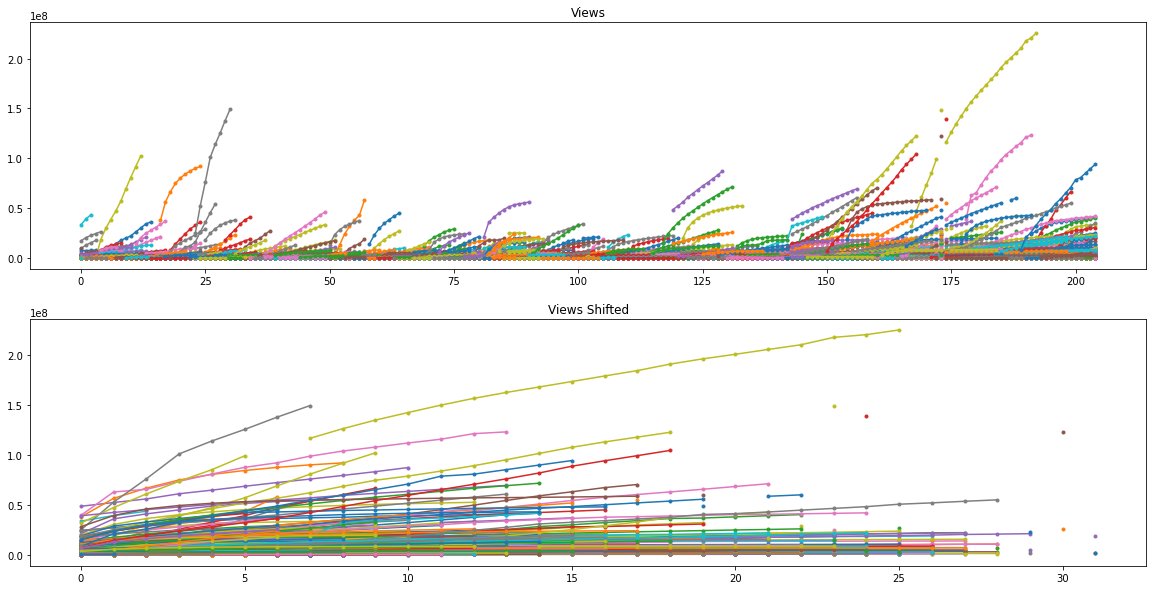

In [390]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
for c in df_chng_per_day_v.columns:
    plt.plot(np.arange(num_rows),df_chng_per_day_v[c],".-")
plt.title("Views")

plt.subplot(2,1,2)
for c in df_chng_per_day_v_shifted.columns:
    plt.plot(df_chng_per_day_v_shifted[c],".-")
plt.title("Views Shifted")

(array([708., 527., 586., 549., 687., 766., 710., 353., 256., 158., 180.,
        167., 178., 146.,   0.,  94.,  51.,  40.,  40.,  25.,  23.,  21.,
         17.,  13.,  10.,  16.,   6.,  13.,   9.,   2.]),
 array([ 1.        ,  1.93333333,  2.86666667,  3.8       ,  4.73333333,
         5.66666667,  6.6       ,  7.53333333,  8.46666667,  9.4       ,
        10.33333333, 11.26666667, 12.2       , 13.13333333, 14.06666667,
        15.        , 15.93333333, 16.86666667, 17.8       , 18.73333333,
        19.66666667, 20.6       , 21.53333333, 22.46666667, 23.4       ,
        24.33333333, 25.26666667, 26.2       , 27.13333333, 28.06666667,
        29.        ]),
 <BarContainer object of 30 artists>)

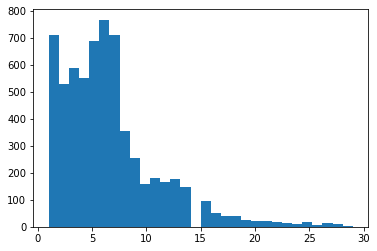

In [201]:
plt.hist(df_chng_per_day_v_shifted.notnull().sum(),bins=30)

Text(0.5, 1.0, 'Views shifted interpolated')

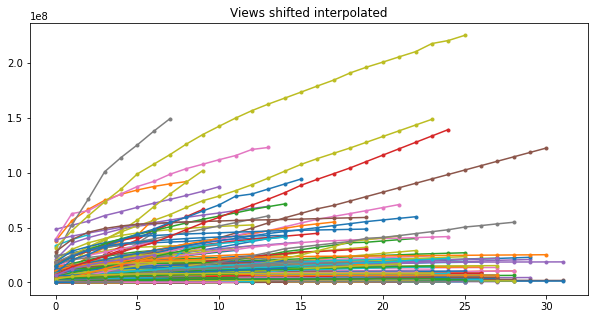

In [393]:
# fill na with interpolant
plt.figure(figsize=(10,5))
for c in df_chng_per_day_v_shifted.columns:
    temp = df_chng_per_day_v_shifted[c].dropna()
    if len(temp) >1:
        xvals = np.arange(max(temp.index)+1)
        spl = interpolate.interp1d(temp.index,temp)
        df_chng_per_day_v_shifted.loc[xvals,c] = spl(xvals)
    
for c in df_chng_per_day_v_shifted.columns:
    plt.plot(df_chng_per_day_v_shifted[c],".-")
plt.title("Views shifted interpolated")

# Diffrent metrics

In [627]:
def tsne_plots(df,metric="euclidean",label=None,perplexity_values = [5,10,20,30,40,50],randState_values=[100,200],figsize=(10,5),tight_layout=True):
    fig, ax = plt.subplots(len(perplexity_values),len(randState_values),figsize=figsize)
    for i in range(len(perplexity_values)):
        for j in range(len(randState_values)):
            # Get projected data
            proj = TSNE(2,perplexity=perplexity_values[i],
                        random_state=randState_values[j]).fit_transform(df)
            proj = pd.DataFrame(proj,columns=["x","y"])
            # Plot on ax
            if label is None:
                sns.scatterplot(x="x",
                                y="y",
                                data=proj,
                                ax=ax[i,j])
            else:
                sns.scatterplot(x="x",
                                y="y",
                                data=proj,
                                hue=label,
                                ax=ax[i,j])
            ax[i,j].set_title(f"perp:{perplexity_values[i]}\n randstate:{randState_values[j]}")

    if tight_layout:
        plt.tight_layout()

## idk 1

In [503]:
df_chng_per_day_v_shifted.isna().sum().to_numpy()

array([26, 31, 29, ...,  8, 31, 30], dtype=int64)

In [ ]:

# num days in trending
def metric1(x1,x2):
    return np.abs(len(x1[x1>0])-len(x2[x2>0]))**2

# conv
def metric2(x1,x2):
    c = convolve(x1[x1>0],x2[x2>0],method="fft")
    return np.average(c)
    
# This looked pretty good
# euclid
metric3 = "euclidean"


metric = metric2

df_temp = df_chng_per_day_v_shifted.fillna(0).T
tsne_plots(df_temp,
           metric=metric,
           figsize=(15,20),
           label=df_chng_per_day_v_shifted.isna().sum().to_numpy())

# League

In [ ]:
df_league_raw = pd.read_csv("data/league_matches.csv")

# Drop columns that are differences
# diff_cols = [col for col in df_league_raw.columns if 'Diff' in col]
# df_league_blue_win = df_league_raw.copy().drop(columns=diff_cols)
df_league_raw.rename(columns={'blueWins':'winningTeam'}, inplace=True)
df_league_raw.rename(columns={'blueWins':'winningTeam'}, inplace=True) # 1 for the blue winning

# Reindex features so that winning teams are in the same column
df_league_blue_win = df_league_raw[df_league_raw["winningTeam"]==1].copy()
df_league_blue_win.columns = [col.replace("blue","winner") for col in df_league_blue_win.columns]
df_league_blue_win.columns = [col.replace("red","loser") for col in df_league_blue_win.columns]

df_league_red_win = df_league_raw[df_league_raw["winningTeam"]==0].copy()
df_league_red_win.columns = [col.replace("blue","loser") for col in df_league_red_win.columns]
df_league_red_win.columns = [col.replace("red","winner") for col in df_league_red_win.columns]

df_league = pd.concat([df_league_red_win,df_league_blue_win])
df_league = df_league.sample(frac=1)

df_league_numeric = df_league.drop(columns=["winningTeam","gameId"]).copy()
# Drop columns that are differences
diff_cols = [col for col in df_league_numeric.columns if 'Diff' in col]
df_league_numeric = df_league_numeric.drop(columns=diff_cols)
# Remove deaths
df_league_numeric = df_league_numeric.drop(columns=["winnerDeaths","loserDeaths"])

## Descriptive Analysis

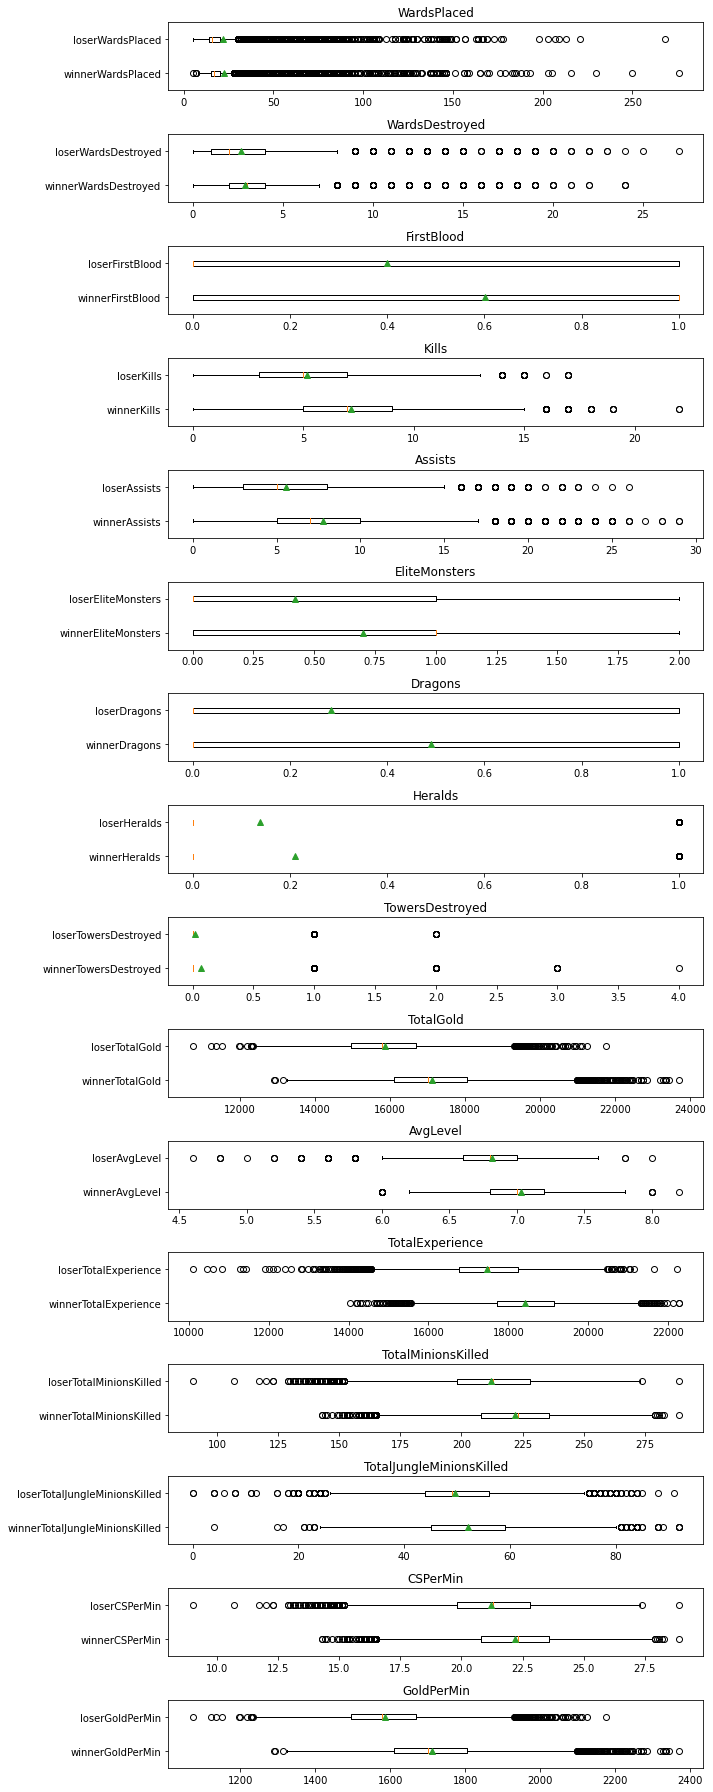

In [612]:
base_column_names = [col.replace("winner","") for col in df_league_numeric.columns if "winner" in col]

plt.figure(figsize=(10,25))
count = 1
for b in base_column_names:
    plt.subplot(len(base_column_names),1,count)
    cols = ["winner"+b,"loser"+b]
    plt.boxplot(df_league_numeric[cols],vert=False,showmeans=True)
    plt.yticks(ticks=[1,2],labels=cols)
    plt.title(b)
    count+=1
plt.tight_layout()

## TSNE plot 

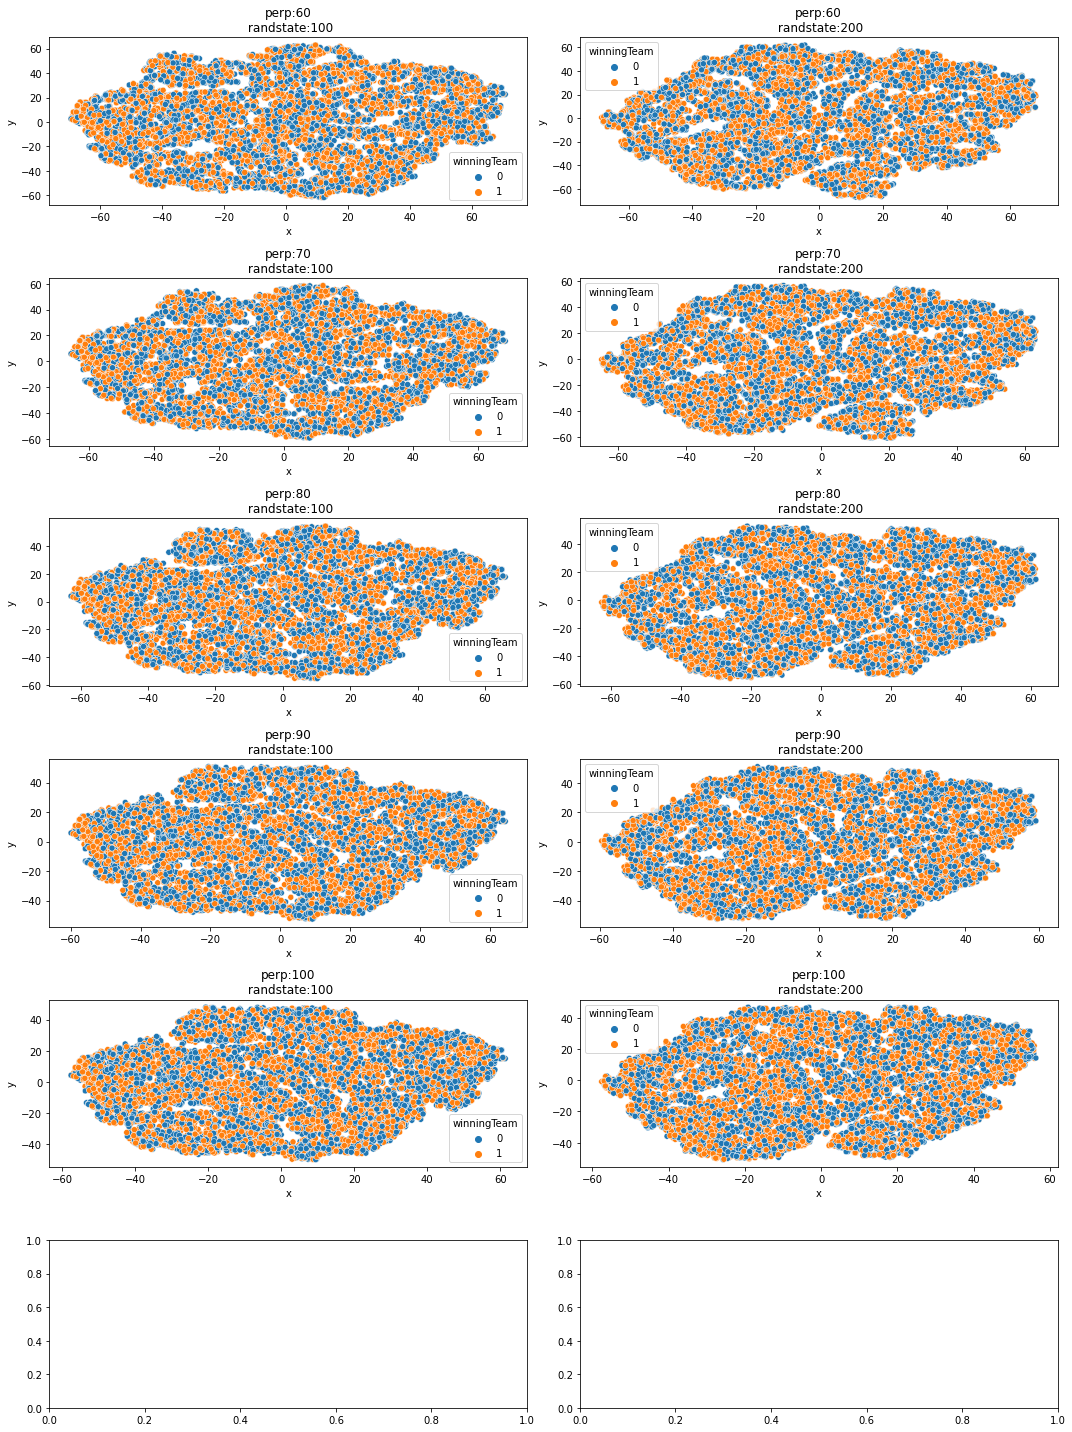

In [616]:
tsne_plots(df_league_numeric,
           figsize=(15,20),
           perplexity_values=[60,70,80,90,100],
           label=df_league_raw["winningTeam"])

# NBA

In [630]:
df_nba_raw = pd.read_csv("data/nba_2013.csv")
df_nba_numeric = df_nba_raw.select_dtypes([np.number])
df_nba_numeric = df_nba_numeric.dropna(axis=1)
df_nba_scaled = StandardScaler().fit_transform(df_nba_numeric)
df_nba_scaled = pd.DataFrame(df_nba_scaled)

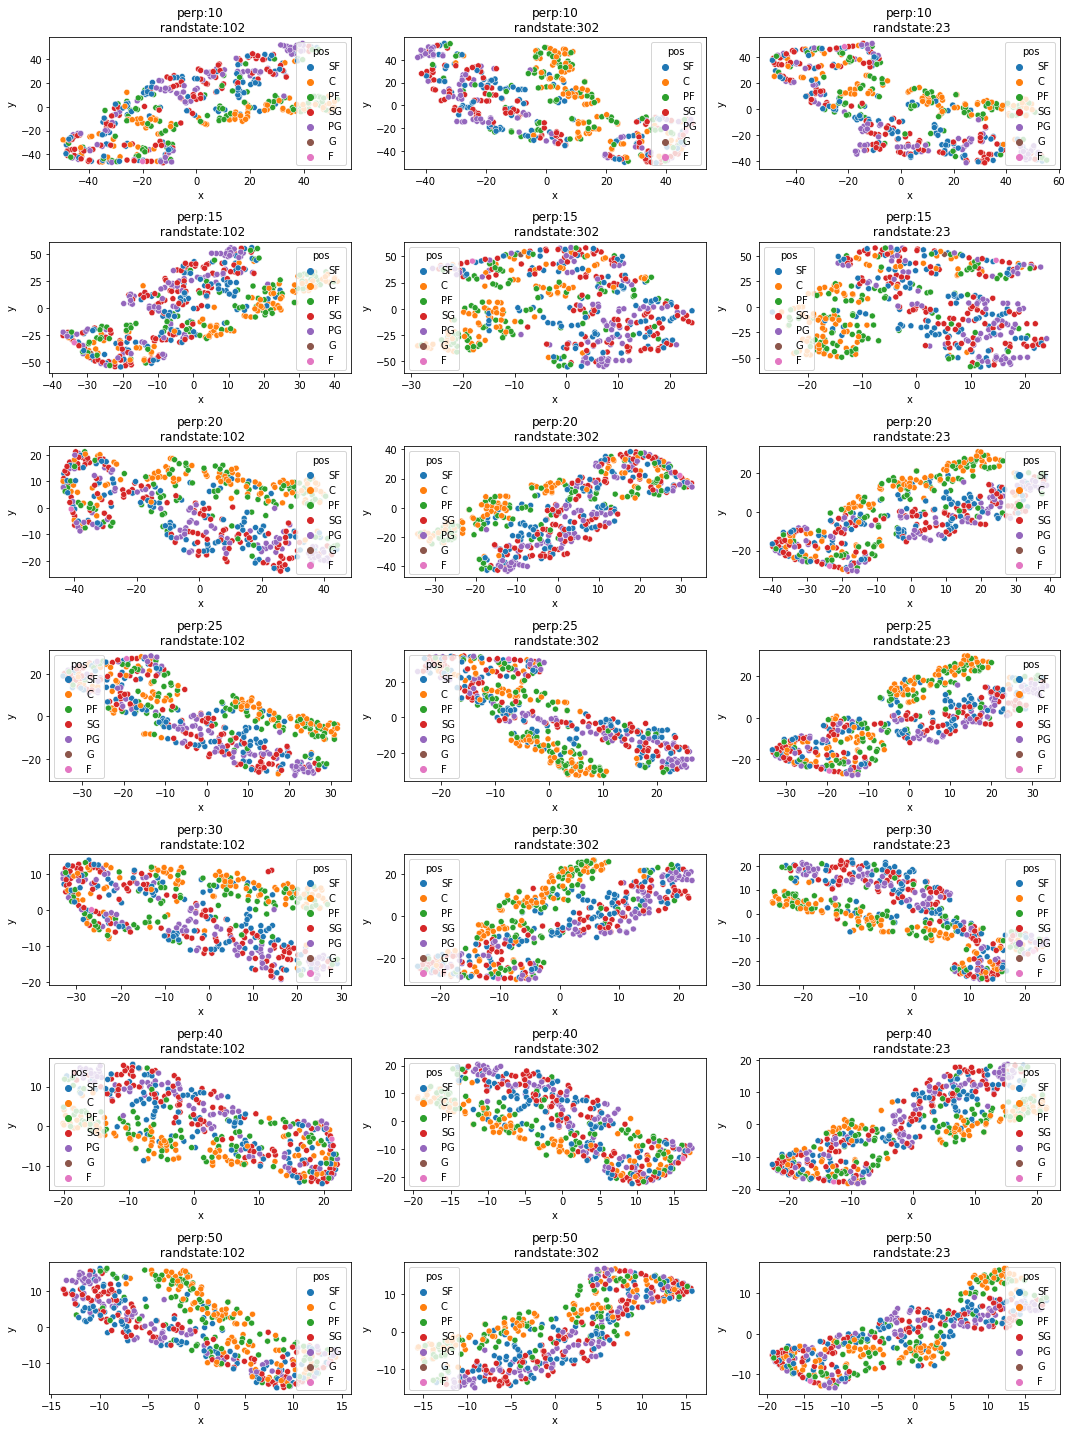

In [632]:
tsne_plots(df_nba_scaled,
           figsize=(15,20),
           perplexity_values=[10,15,20,25,30,40,50],
           randState_values=[102,302,23],
           label=df_nba_raw["pos"])